In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from MonteCarlo import MonteCarlo
import random 
import scipy
import matplotlib.pyplot as plt 

we need to check following arbitrage free conditions: For strike $K_i$, time to maturity $\tau$
$$ \left(S_{0}-K_{i} e^{-r \tau}\right)^{+}<c_{0}<S_{0} $$
$$ \frac{C_{i, j}-C_{i-1, j}}{K_{i}-K_{i-1}} \in [-1,0] $$
$$ C_{i-1, j}-C_{i, j} \geqslant \frac{K_{i}-K_{i-1}}{K_{i+1}-K_{i}}\left(C_{i, j}-C_{i+1, j}\right) $$
$$ C_{i, j+1}-C_{i, j} \geq 0 $$

# Arbitrage Check

In [25]:
def arbitrage_check(data):
    cols = ['moneyness', 'tau', 'r', 'vol', 'C']
    data = pd.DataFrame(data, columns=cols)
    data['K'] = 1 / data['moneyness']
    data = data.sort_values(by='K')
    data['K-1'] = data['K'].shift(1)
    data['K+1'] = data['K'].shift(-1)
    data['C-1'] = data['C'].shift(1)
    data['C+1'] = data['C'].shift(-1)
    data = data.iloc[1:-1]
    # check 1
    data['check1'] = np.maximum(1 - data['K'] * np.exp(- data['r'] * data['tau']), 0)
    data = data.loc[(data['C'] < 1) & (data['C'] > data['check1'])] 
    # check 2 
    data['check2'] = (data['C'] - data['C-1']) / (data['K'] - data['K-1'])
    data = data.loc[(data['check2'] >= -1) & (data['check2'] <= 0)]
    # check 3
    data['check3'] = (data['C'] - data['C-1']) / (data['C+1'] - data['C']) - (data['K'] - data['K-1']) / (data['K+1'] - data['K'])
    data = data.loc[data['check3'] >= 0]
    print(data)

cols = ['moneyness', 'tau', 'r', 'vol', 'option price']
data = []

vol = random.uniform(0.02, 0.9)
r = random.uniform(0.03, 0.08)
tau = random.uniform(0.3, 0.95)
for i in range(100):
    moneyness = random.uniform(0.7, 1.3)
    K = 1 / moneyness
    MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol, method='MC')
    MC.generate_S(1000,10)
    option_price = MC.pricer(optionType='c', American=False)
    data.append([moneyness, tau, r, vol, option_price])

data = pd.DataFrame(data, columns=cols)
data.to_csv(f'test.csv', index=False)

data = pd.read_csv('test.csv')
arbitrage_check(data.values.tolist())



    moneyness       tau         r       vol         C         K       K-1  \
93   1.240049  0.947815  0.034754  0.113892  0.219958  0.806419  0.799983   
94   1.197096  0.947815  0.034754  0.113892  0.192857  0.835355  0.826091   
88   1.184930  0.947815  0.034754  0.113892  0.184859  0.843932  0.835619   
33   1.135486  0.947815  0.034754  0.113892  0.150988  0.880680  0.865467   
71   1.114445  0.947815  0.034754  0.113892  0.136608  0.897308  0.890082   
6    1.093499  0.947815  0.034754  0.113892  0.121756  0.914496  0.910816   
79   1.092980  0.947815  0.034754  0.113892  0.121411  0.914930  0.914496   
1    1.040590  0.947815  0.034754  0.113892  0.084992  0.960994  0.955599   
58   1.037416  0.947815  0.034754  0.113892  0.083139  0.963933  0.960994   
73   1.013003  0.947815  0.034754  0.113892  0.068397  0.987164  0.980992   
48   0.998283  0.947815  0.034754  0.113892  0.060772  1.001720  0.995496   
37   0.996972  0.947815  0.034754  0.113892  0.059759  1.003037  1.001720   

In [28]:
data.sort_values(by='option price')

,moneyness,tau,r,vol,option price
95,0.711462,0.947815,0.034754,0.113892,0.000108
82,0.720044,0.947815,0.034754,0.113892,0.000205
22,0.718146,0.947815,0.034754,0.113892,0.000232
39,0.748166,0.947815,0.034754,0.113892,0.000353
46,0.741718,0.947815,0.034754,0.113892,0.000358
...,...,...,...,...,...
78,1.277047,0.947815,0.034754,0.113892,0.242530
76,1.283061,0.947815,0.034754,0.113892,0.245882
45,1.289540,0.947815,0.034754,0.113892,0.250336
51,1.292438,0.947815,0.034754,0.113892,0.251544


# European call

## Basic Research

### BS formula

In [2]:
def formula_price(spot, strike, vol, tau, r, phi):
    # phi = 1 -> call option, phi = -1 -> put option
    var = vol * np.sqrt(tau)
    d1 = (np.log(spot / strike) + r * tau + 0.5 * var ** 2) / var
    d2 = d1 - var

    v1 = scipy.stats.norm.cdf(phi * d1)
    v2 = scipy.stats.norm.cdf(phi * d2)

    price = phi * (spot * v1 - strike * np.exp(-r * tau) * v2)

    return price


### GBM: MonteCarlo & BS formula

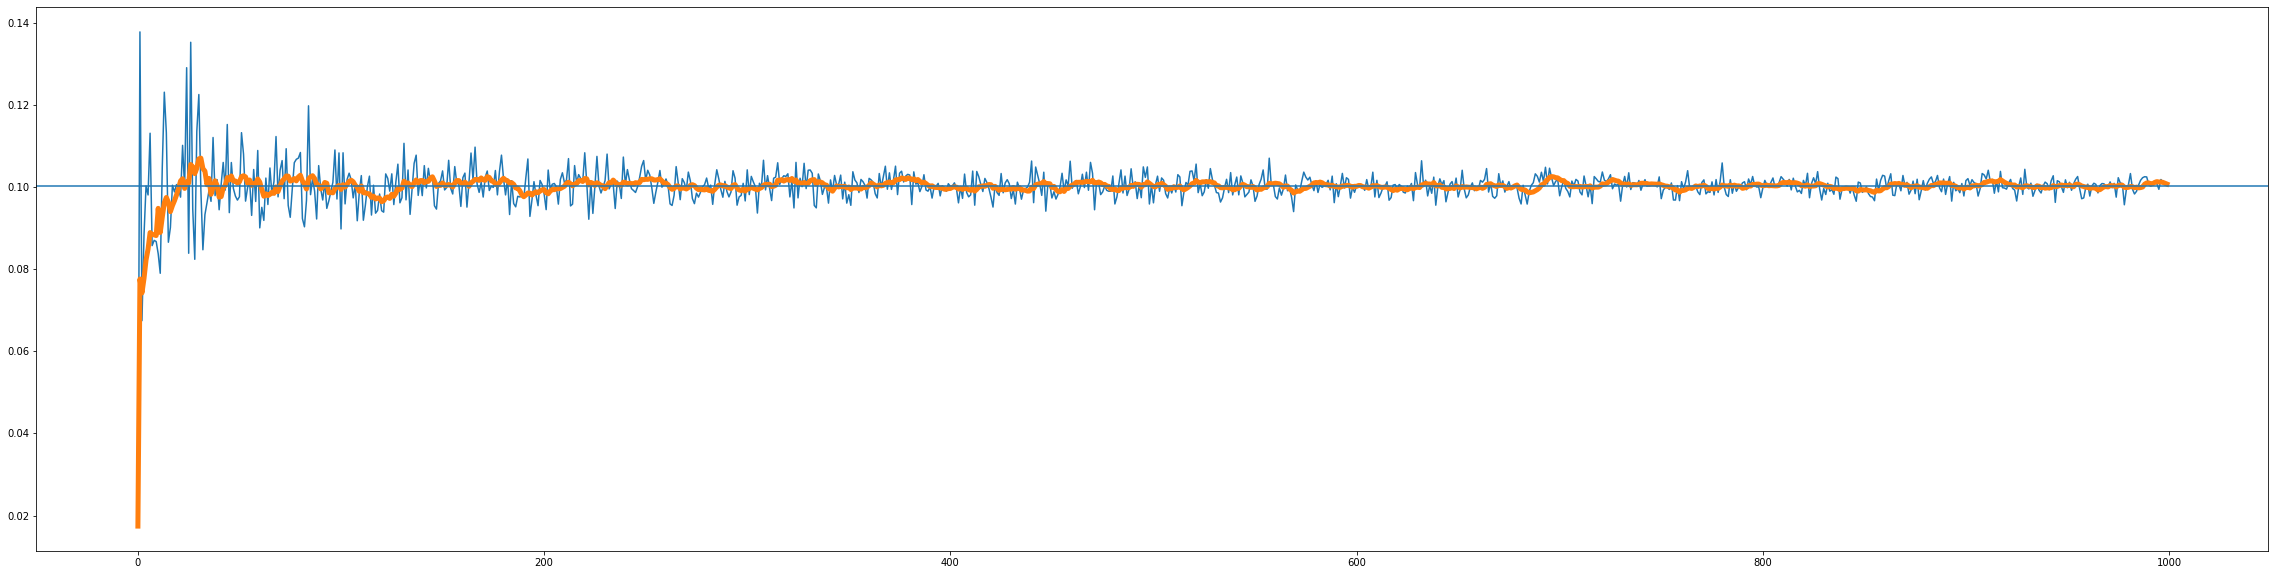

In [19]:
r = 0.05
tau = 1
spot = 1
strike = 1.1
vol = 0.3
phi = 1 
# use closed-from formula 
fm_price = formula_price(spot, strike, vol, tau, r, phi)
# use Monte Carlo
MC = MonteCarlo(model='GBM', S0=spot, K=strike, T=tau, r=r, q=0, v=vol)
mc_prices = []
for n_paths in np.arange(10, 10000+10, 10):
    mc_prices.append(MC.pricer(n_paths, 1, optionType='c', European=True, antiVar=True))
S_paths = MC.get_path('S')

plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)
plt.axhline(fm_price)

In [21]:
pd.Series(S_paths[:,0]).describe()

count    10000.000000
mean         1.051509
std          0.323766
min          0.325785
25%          0.821936
50%          1.005013
75%          1.228867
max          3.100362
dtype: float64

(array([  1.,   8.,   7.,  14.,  29.,  39.,  35.,  73., 114., 131., 183.,
        182., 218., 233., 275., 304., 337., 362., 358., 383., 387., 362.,
        410., 366., 384., 356., 360., 320., 297., 312., 275., 265., 231.,
        231., 203., 181., 184., 138., 156., 139., 101.,  88.,  95.,  93.,
         68.,  80.,  77.,  70.,  47.,  54.,  51.,  37.,  37.,  31.,  31.,
         19.,  20.,  21.,  11.,  11.,   8.,   6.,  11.,   9.,  11.,  10.,
          2.,   8.,   6.,   6.,   6.,   3.,   5.,   3.,   3.,   1.,   1.,
          0.,   0.,   1.,   2.,   1.,   1.,   2.,   4.,   1.,   1.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.32578464, 0.35353041, 0.38127618, 0.40902195, 0.43676772,
        0.46451348, 0.49225925, 0.52000502, 0.54775079, 0.57549656,
        0.60324233, 0.6309881 , 0.65873387, 0.68647964, 0.71422541,
        0.74197117, 0.76971694, 0.79746271, 0.82520848, 0.85295425,
        0.88070002, 0.90844579, 0.93619156, 0.

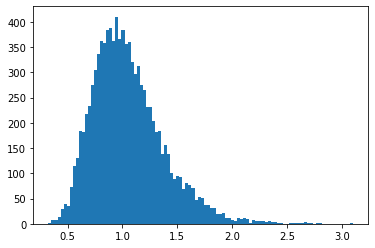

In [22]:
plt.hist(S_paths, bins=100)

### Heston: MonteCarlo & BS formula (fix $n_{steps}$, change $n_{paths}$)

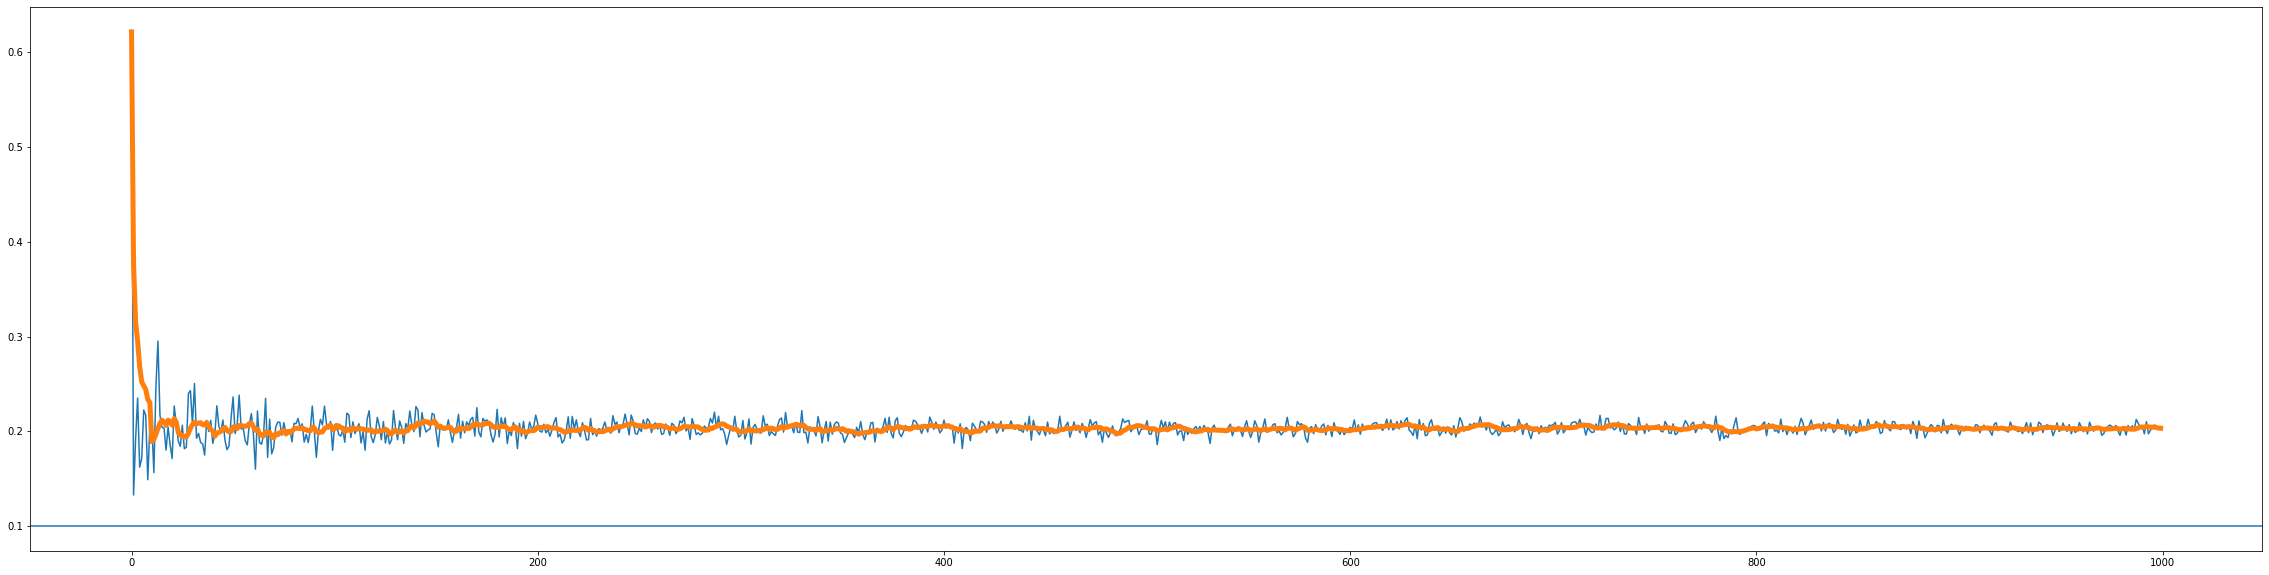

In [33]:
r = 0.05
tau = 1
spot = 1
strike = 1.1
vol = 0.3
phi = 1 
# use closed-from formula 
fm_price = formula_price(spot, strike, vol, tau, r, phi)
# use Monte Carlo
MC = MonteCarlo(model='Heston', S0=spot, K=strike, T=tau, r=r, q=0, v0=0.3, theta=0.3, kappa=0.5, gamma=0.3, rho=0.5)
mc_prices = []
for n_paths in np.arange(10, 10000+10, 10):
    mc_prices.append(MC.pricer(n_paths, 10, optionType='c', European=True, antiVar=True))
vol_paths = MC.get_path('v')
S_paths = MC.get_path('S')

plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)
plt.axhline(fm_price)


In [24]:
pd.DataFrame(vol_paths)

,0,1,2,3,4,5,6,7,8,9,10
0,0.3,0.320681,0.191907,0.209281,0.137921,0.171245,0.161476,0.154252,0.158206,0.117688,0.181445
1,0.3,0.234270,0.232079,0.287630,0.297935,0.331858,0.301828,0.240555,0.185311,0.184164,0.136869
2,0.3,0.329627,0.297567,0.261907,0.256753,0.238734,0.266181,0.226492,0.286015,0.372851,0.275256
3,0.3,0.319743,0.313509,0.256966,0.259773,0.303876,0.207557,0.159552,0.196458,0.217815,0.210132
4,0.3,0.284246,0.262772,0.167811,0.187237,0.169323,0.218041,0.209558,0.121768,0.141070,0.136082
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.3,0.259921,0.279225,0.183364,0.073227,0.100606,0.122139,0.122497,0.149148,0.064458,0.060908
9996,0.3,0.263576,0.206477,0.231916,0.241415,0.255765,0.160878,0.194766,0.286659,0.332078,0.376370
9997,0.3,0.339632,0.354172,0.293032,0.255930,0.279371,0.249335,0.201212,0.155104,0.142606,0.084448
9998,0.3,0.324940,0.174530,0.167580,0.182950,0.277707,0.316212,0.341617,0.258084,0.227677,0.219716


(array([  1.,   1.,   0.,   3.,   5.,  12.,   7.,  21.,  33.,  54.,  59.,
         60., 100., 101., 126., 145., 146., 188., 224., 223., 226., 241.,
        268., 316., 306., 290., 295., 318., 287., 300., 304., 304., 295.,
        288., 265., 280., 269., 253., 247., 223., 206., 205., 215., 216.,
        147., 188., 167., 141., 134., 118., 126., 112.,  82.,  81.,  88.,
         59.,  60.,  47.,  59.,  44.,  38.,  38.,  38.,  47.,  32.,  28.,
         15.,  25.,  24.,  19.,  18.,  17.,   8.,  14.,   8.,   9.,   6.,
          3.,   9.,   3.,   3.,   2.,   2.,   1.,   1.,   2.,   2.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          1.]),
 array([0.00558527, 0.01195141, 0.01831755, 0.02468368, 0.03104982,
        0.03741596, 0.0437821 , 0.05014824, 0.05651438, 0.06288052,
        0.06924665, 0.07561279, 0.08197893, 0.08834507, 0.09471121,
        0.10107735, 0.10744349, 0.11380963, 0.12017576, 0.1265419 ,
        0.13290804, 0.13927418, 0.14564032, 0.

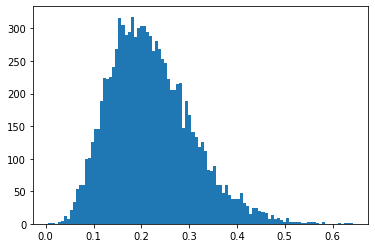

In [25]:
plt.hist(pd.DataFrame(vol_paths).iloc[:, -1], bins=100)

<Figure size 2880x1440 with 0 Axes>

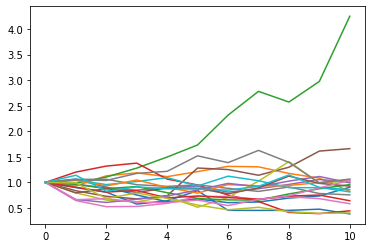

In [26]:
plt.figure(figsize=(40,20))
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(S_paths.T).iloc[:, 0:20])

In [28]:
pd.DataFrame(S_paths).iloc[:, -1].describe()

count    10000.000000
mean         1.049227
std          0.585857
min          0.114744
25%          0.656090
50%          0.913961
75%          1.285943
max          8.844063
Name: 10, dtype: float64

<BarContainer object of 100 artists>

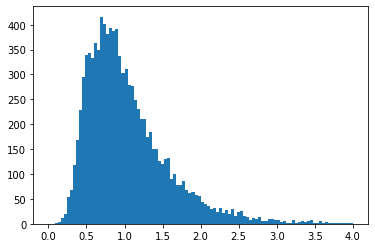

In [31]:
_, _, fig = plt.hist(pd.DataFrame(S_paths).iloc[:, -1], bins=100, range=(0,4))
fig

### Heston: MonteCarlo & BS formula (fix $n_{paths}$, change $n_{steps}$)

100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


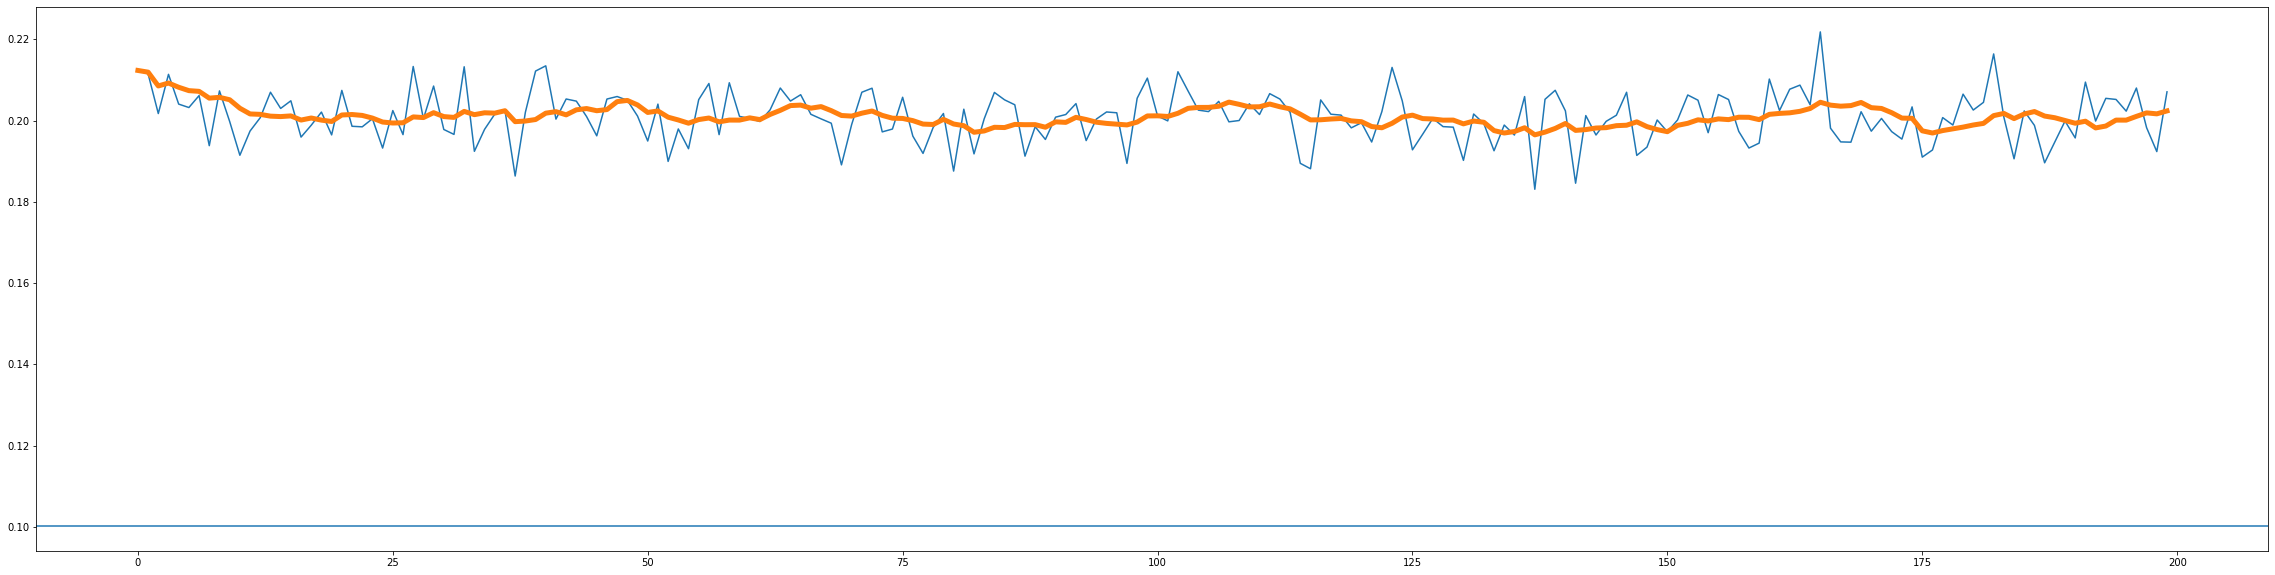

In [34]:
r = 0.05
tau = 1
spot = 1
strike = 1.1
vol = 0.3
phi = 1 
# use closed-from formula 
fm_price = formula_price(spot, strike, vol, tau, r, phi)
# use Monte Carlo
MC = MonteCarlo(model='Heston', S0=spot, K=strike, T=tau, r=r, q=0, v0=0.3, theta=0.3, kappa=1.5, gamma=0.3, rho=0.5)
mc_prices = []
for n_steps in tqdm(np.arange(5, 1000+5, 5)):
    mc_prices.append(MC.pricer(5000, n_steps, optionType='c', European=True, antiVar=True))
plt.figure(figsize=(40,10))
plt.plot(mc_prices)
plt.plot(pd.Series(mc_prices).rolling(10, min_periods=1).mean(), linewidth=5)
plt.axhline(fm_price)

## Predict Option Price

### Data generation

In [41]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

American = False if Type == 'European' else True
optionType = 'c' if option == 'call' else 'p'

cols = ['moneyness', 'tau', 'r', 'vol', 'option price']
data = []

while len(data) < 50000:
    for i in tqdm(range(5000)):
        vol = random.uniform(0.02, 0.9)
        r = random.uniform(0.03, 0.08)
        tau = random.uniform(0.3, 0.95)
        moneyness = random.uniform(0.7, 1.3)
        K = 1 / moneyness
        MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol)
        option_price = MC.pricer(10000, 1, optionType='c', European=True, antiVar=True)
        if option_price > 0.01:
            data.append([moneyness, tau, r, vol, option_price])

data = pd.DataFrame(data, columns=cols)
data.to_csv(f'data_{model}_{Type}_{option}.csv', index=False)



100%|██████████| 5000/5000 [00:01<00:00, 2736.27it/s]


In [42]:
data.sort_values(by='option price')

,moneyness,tau,r,vol,option price
15493,0.741975,0.528020,0.041287,0.284660,0.010025
18160,0.841620,0.411307,0.047684,0.211567,0.010034
46338,0.934711,0.663972,0.070543,0.056509,0.010047
9403,0.979890,0.431559,0.040220,0.044401,0.010054
33813,0.817201,0.367896,0.038223,0.262868,0.010055
...,...,...,...,...,...
24453,1.295261,0.947648,0.058028,0.898446,0.437974
27855,1.289417,0.910191,0.056907,0.889100,0.439625
49099,1.240080,0.927890,0.073182,0.898977,0.441070
44361,1.266840,0.930377,0.072174,0.890826,0.445121


In [4]:
data.describe()

,moneyness,tau,r,vol,option price
count,10537.000000,10537.000000,10537.000000,10537.000000,10537.000000
mean,1.063708,0.643051,0.055380,0.542235,0.218922
std,0.157691,0.184528,0.014396,0.237476,0.071644
min,0.700032,0.300022,0.030001,0.020041,0.100056
25%,0.949484,0.488232,0.043024,0.362569,0.160809
50%,1.087720,0.650307,0.055603,0.578912,0.215439
75%,1.194842,0.802350,0.067763,0.740467,0.267869
max,1.299951,0.949958,0.079999,0.899886,0.430429


### GridSearch 

In [31]:
data = pd.read_csv(f'data_{model}_{Type}_{option}.csv')

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

scoring = {
    'r2':'r2', 
    'MSE': make_scorer(mean_squared_error),
    'MAPE': make_scorer(mean_absolute_percentage_error),
    'MAE': make_scorer(mean_absolute_error),    
    }
param_grid = {
    'activation': ['relu'],
    'solver': ['adam'],
    'hidden_layer_sizes': 
        [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + 
        [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + 
        [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)],
    'max_iter': [500],
    'learning_rate_init': np.arange(0.005, 0.005+0.001, 0.001),
}
MLP = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.02, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
search = GridSearchCV(MLP, param_grid=param_grid, cv=5, scoring = scoring, refit='MSE', return_train_score=True, verbose=4, n_jobs=3)
search.fit(x,y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 3/5] END activation=logistic, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.071, test=0.070) MSE: (train=0.000, test=0.000) r2: (train=0.942, test=0.943) total time=   1.6s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.068, test=0.068) MSE: (train=0.000, test=0.000) r2: (train=0.942, test=0.942) total time=   3.8s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=logistic, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.068, test=0.068) MSE: (train=0.000, test=0.000) r2: (train=0.945, test=0.945) total time=   5.1s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.011, test=0.011) MAPE: (train=0.059, test=0.058) MSE: (train=0.000, test=0.000) r2: (train=0.947, test=0.947) total time=   4.7s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.067, test=0.067) MSE: (train=0.000, test=0.000) r2: (train=0.941, test=0.941) total time=   2.4s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.011, test=0.012) MAPE: (train=0.061, test=0.064) MSE: (train=0.000, test=0.000) r2: (train=0.954, test=0.953) total time=   5.1s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.066, test=0.065) MSE: (train=0.000, test=0.000) r2: (train=0.941, test=0.943) total time=   1.5s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.014, test=0.013) MAPE: (train=0.074, test=0.073) MSE: (train=0.000, test=0.000) r2: (train=0.942, test=0.943) total time=   3.8s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.068, test=0.067) MSE: (train=0.000, test=0.000) r2: (train=0.94

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.028, test=0.028) MSE: (train=0.000, test=0.000) r2: (train=0.991, test=0.991) total time=   7.9s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=logistic, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.029, test=0.029) MSE: (train=0.000, test=0.000) r2: (train=0.991, test=0.991) total time=   8.2s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.023, test=0.023) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.994) total time=   8.1s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.069, test=0.068) MSE: (train=0.000, test=0.000) r2: (train=0.942, test=0.940) total time=  51.3s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.008, test=0.008) MAPE: (train=0.048, test=0.047) MSE: (train=0.000, test=0.000) r2: (train=0.975, test=0.974) total time=  11.9s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.014, test=0.014) MAPE: (train=0.075, test=0.077) MSE: (train=0.000, test=0.000) r2: (train=0.938, test=0.938) total time=  52.0s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.012) MAPE: (train=0.066, test=0.065) MSE: (train=0.000, test=0.000) r2: (train=0.942, test=0.940) total time=   2.2s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.065, test=0.066) MSE: (train=0.000, test=0.000)

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.031, test=0.032) MSE: (train=0.000, test=0.000) r2: (train=0.989, test=0.989) total time=  10.6s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.012, test=0.013) MAPE: (train=0.065, test=0.065) MSE: (train=0.000, test=0.000) r2: (train=0.941, test=0.941) total time=   4.4s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.013, test=0.013) MAPE: (train=0.065, test=0.065) MSE: (train=0.000, test=0.000) r2: (train=0.938, test=0.940) total time=   3.0s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(32, 32, 32), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.014, test=0.013) MAPE: (train=0.074, test=0.073) MSE: (train=0.000, test=0.00

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=logistic, hidden_layer_sizes=(8, 8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.011, test=0.012) MAPE: (train=0.059, test=0.061) MSE: (train=0.000, test=0.000) r2: (train=0.957, test=0.956) total time=   8.3s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.014, test=0.014) MAPE: (train=0.076, test=0.076) MSE: (train=0.000, test=0.000) r2: (train=0.939, test=0.939) total time=   3.9s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.022, test=0.021) MSE: (train=0.000, test=0.000) r2: (train=0.995, test=0.995) total time=  13.4s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.021, test=0.022) MSE: (train=0.000, test=0.000) r2: (train=0.995, test=0.995) total time=  13.3s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(32, 32, 32, 32), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.060, test=0.059) MAPE: (train=0.328, test=0.318) MSE: (train=0.005, test=0.005) r2: (train=-0.004, test=-0.001) total time=   0.9s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(16, 16, 16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.015, test=0.015) MAPE: (train=0.082, test=0.082) MSE: (trai

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.024, test=0.025) MSE: (train=0.000, test=0.000) r2: (train=0.993, test=0.992) total time=   7.0s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.009, test=0.009) MAPE: (train=0.048, test=0.046) MSE: (train=0.000, test=0.000) r2: (train=0.972, test=0.974) total time=   7.3s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(256, 256, 256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.059, test=0.061) MAPE: (train=0.322, test=0.330) MSE: (train=0.005, test=0.005) r2: (train=-0.005, test=-0.003) total time=  23.4s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.025, test=0.024) MSE: (train=0.000, test=0.000) r2: (train=0.993, test=0.994) total time=   9.7s


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, hidden_layer_sizes=(8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.021, test=0.021) MSE: (train=0.000, test=0.000) r2: (train=0.995, test=0.995) total time=   9.4s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.006, test=0.006) MAPE: (train=0.031, test=0.031) MSE: (train=0.000, test=0.000) r2: (train=0.990, test=0.989) total time=   3.2s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.019, test=0.019) MSE: (train=0.000, test=0.000) r2: (train=0.996, test=0.996) total time=   3.0s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(16, 16), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.027, test=0.026) MSE: (train=0.000, test=0.000) r2: (train=0.993, test=0.993) t

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.023, test=0.025) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.993) total time=  14.1s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.022, test=0.022) MSE: (train=0.000, test=0.000) r2: (train=0.995, test=0.994) total time=   5.6s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.024, test=0.023) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.994) total time=   8.0s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.023, test=0.023) MSE: (train=0.000, test=0.000) r2: (train=0.994, test=0.

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, hidden_layer_sizes=(256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.028, test=0.027) MSE: (train=0.000, test=0.000) r2: (train=0.992, test=0.992) total time= 2.9min
[CV 2/5] END activation=tanh, hidden_layer_sizes=(64, 64, 64), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.002, test=0.002) MAPE: (train=0.012, test=0.013) MSE: (train=0.000, test=0.000) r2: (train=0.998, test=0.998) total time=  23.3s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(64, 64, 64), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.003, test=0.003) MAPE: (train=0.017, test=0.017) MSE: (train=0.000, test=0.000) r2: (train=0.997, test=0.996) total time=  27.1s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(64, 64, 64), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.027, test=0.027) MSE: (train=0.000, test=0.000) r2: (train=0.99

/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.003, test=0.003) MAPE: (train=0.017, test=0.017) MSE: (train=0.000, test=0.000) r2: (train=0.997, test=0.996) total time= 5.7min


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.020, test=0.021) MSE: (train=0.000, test=0.000) r2: (train=0.996, test=0.995) total time= 5.8min


/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.003, test=0.003) MAPE: (train=0.018, test=0.018) MSE: (train=0.000, test=0.000) r2: (train=0.996, test=0.996) total time= 5.8min
[CV 1/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.002, test=0.002) MAPE: (train=0.013, test=0.013) MSE: (train=0.000, test=0.000) r2: (train=0.998, test=0.998) total time=   6.7s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.005, test=0.005) MAPE: (train=0.026, test=0.027) MSE: (train=0.000, test=0.000) r2: (train=0.992, test=0.991) total time=   4.4s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(8, 8, 8, 8), learning_rate_init=0.005, max_iter=500, solver=adam; MAE: (train=0.004, test=0.004) MAPE: (train=0.024, test=0.023) MSE: (train=0.000, test=0.000) r2: (train

KeyboardInterrupt: 

In [6]:
search.cv_results_

{'mean_fit_time': array([ 3.11932492,  3.09468063,  3.88210638,  6.33453067, 23.2832106 ,
        42.13535802,  3.27311118,  3.03968771,  3.28887971,  4.35198983,
         4.96050763, 14.33884764,  3.83869608,  3.09853538,  4.58223295,
         4.55477913,  7.70102318, 21.48735515,  1.5271457 ,  2.92117492,
         6.75823243, 17.92416128, 41.67616073, 68.18525942,  1.9107457 ,
         4.10255361,  9.1273183 , 23.72158734, 24.43632499, 16.86052815,
         2.88715235,  2.73964373,  6.57039841, 10.98808996, 21.01670464,
        25.69916821,  1.92987569,  1.78623025,  2.22022096,  2.36539666,
         6.29528904, 19.12512668,  0.66204866,  1.42757575,  2.69754926,
         3.73380502,  5.88949633, 35.25627947,  1.79704698,  1.35481675,
         2.29301866,  3.4771502 , 10.39745498, 26.29678742]),
 'std_fit_time': array([1.73071106, 1.28591816, 0.37357458, 0.70045591, 6.30986761,
        6.24130006, 1.5577388 , 1.10930243, 2.34424124, 2.3118937 ,
        1.00371797, 1.95959741, 0.55166

In [7]:
search.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (256, 256, 256, 256),
 'learning_rate_init': 0.02,
 'max_iter': 500,
 'solver': 'adam'}

In [10]:
search.best_score_

0.005157212105318282

### Single Model

In [45]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

# hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
hls_set = [(32,32,32,32)]
for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log.txt', 'a') as f:
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        # f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        # f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        # f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        # f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        # f.write(f'MAPE: {mape_score}\n\n')

(50723, 5)
(32, 32, 32, 32)

r2: [0.9978805  0.99602058 0.99801876]

MSE: [-1.70080762e-05 -1.62412535e-05 -1.95173911e-05]

MAE: [-0.00419398 -0.00494989 -0.00747719]

MAPE: [-0.03070003 -0.060011   -0.07306604]




(50723, 5)


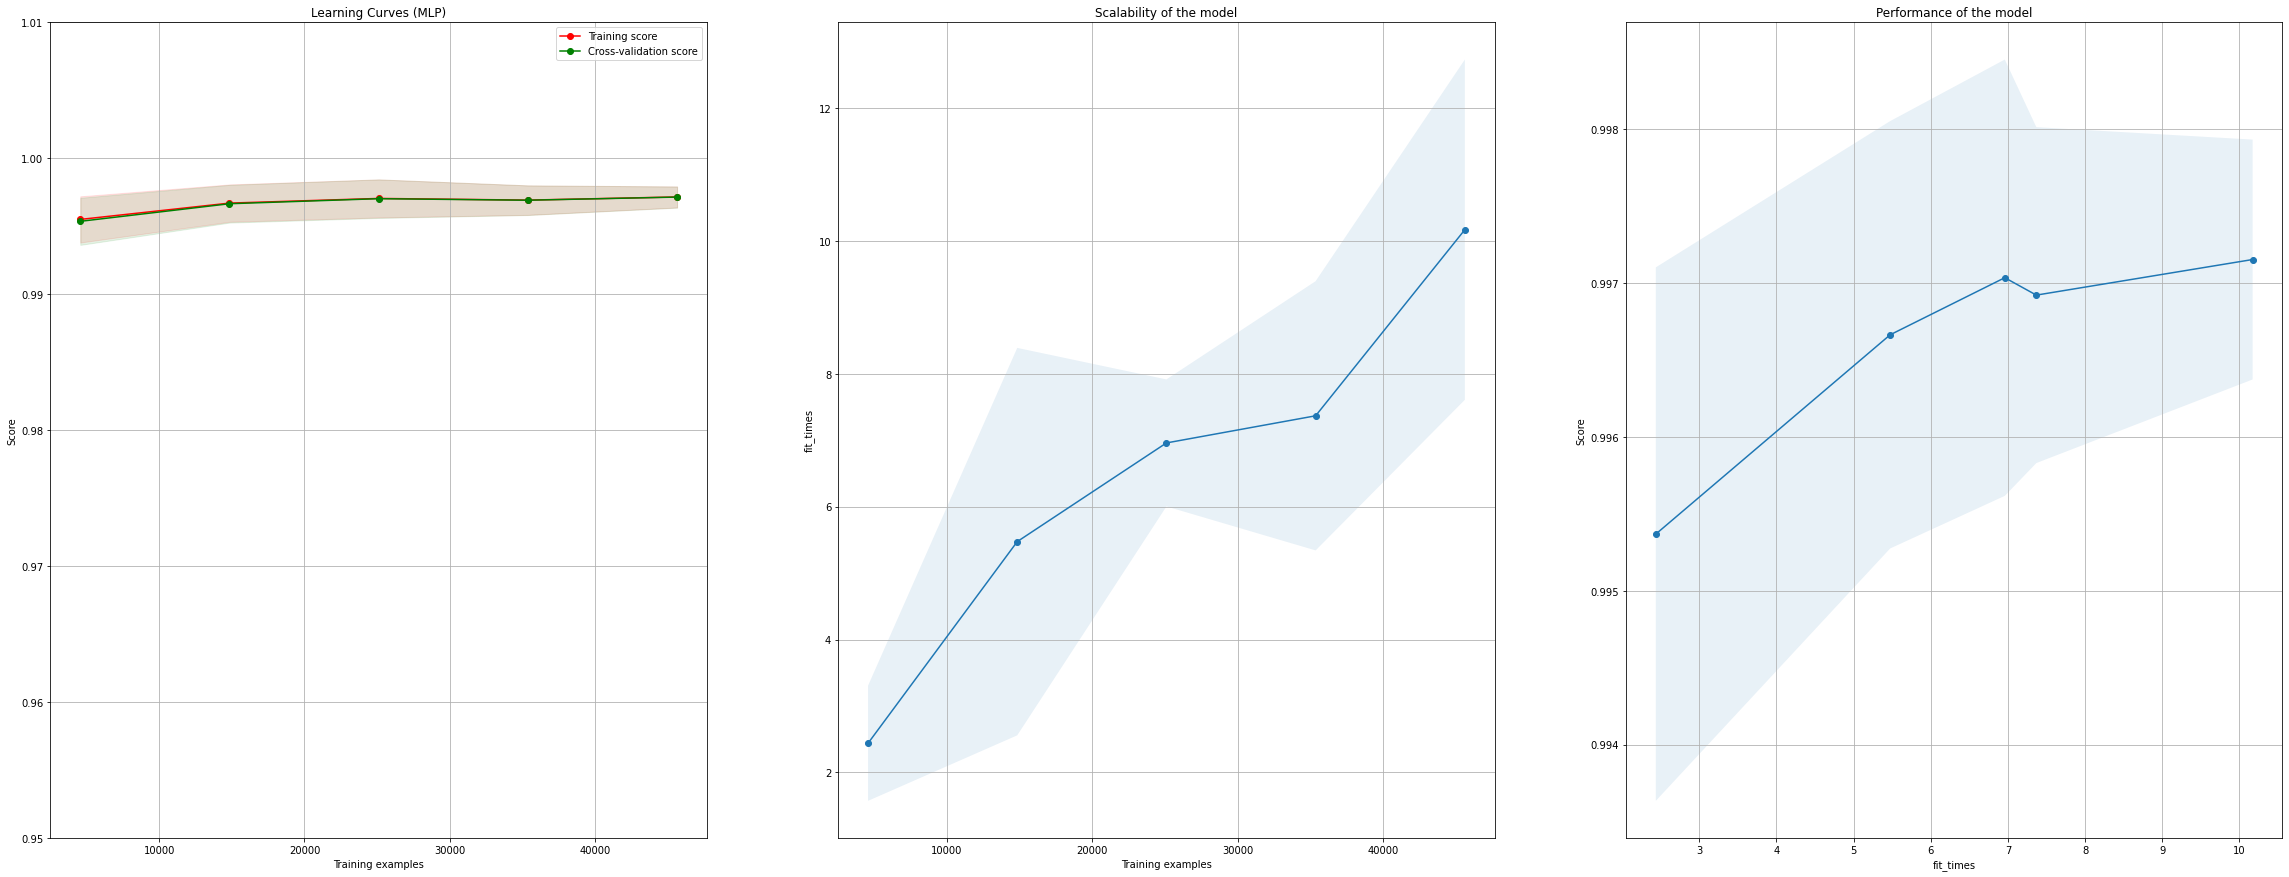

In [43]:
from utils import *
from sklearn.model_selection import ShuffleSplit

model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'data_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'vol']]
y = data['option price']

hidden_layer_sizes = (32,32,32,32)
estimator = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=1024, learning_rate_init=0.005, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)

fig, axes = plt.subplots(1, 3, figsize=(40, 15))

title = "Learning Curves (MLP)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(estimator, title, x, y, axes=axes, ylim=(0.95, 1.01), cv=cv, n_jobs=4)

plt.show()


## Predict Implied volatility

### Data generation

In [35]:
from scipy import optimize
from scipy.stats import norm
import pandas as pd
import numpy as np
from scipy.optimize import fsolve

brentq = optimize.brentq
N = norm.cdf


# brent error?
def IV(S0, K, r, T, V, sigma):
    d1 = (np.log(S0/K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0/K) + (r - 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    return S0 * N(d1) - K * np.exp(-r*T) * N(d2) - V

def IV_solver(S0, K, r, T, V):
    def IV_fsolve(sigma):
        return IV(S0, K, r, T, V, sigma) 

    # return brentq(IV_brentq, a=0, b=1.1)
    return fsolve(IV_fsolve, 0.5)

model = 'GBM' 
Type = 'European' 
option = 'call' 

American = False if Type == 'European' else True
optionType = 'c' if option == 'call' else 'p'

cols = ['moneyness', 'tau', 'r', 'time value', 'implied volatility']
data = []
while len(data) < 10000:
    for i in tqdm(range(5000)):
        vol = random.uniform(0.05, 1.0)
        r = random.uniform(0.0, 0.1)
        tau = random.uniform(0.05, 1.0)
        moneyness = random.uniform(0.5, 1.4)
        K = 1 / moneyness
        MC = MonteCarlo(model='GBM', S0=1, K=K, T=tau, r=r, q=0, v=vol)
        option_price = MC.pricer(10000, 1, optionType='c', European=True, antiVar=True)
        if option_price > 0.01:
            iv = IV_solver(S0=1, K=K, r=r, T=tau, V=option_price)
            # Intrinsic_value = np.maximum(1 - K * np.exp(- r * tau), 0)
            # Time_value = option_price - Intrinsic_value
            # if Time_value < 1e-7:
            #     continue
            # log_TV_K = np.log( Time_value / K)
            if iv[0] > 0.05:
                data.append([moneyness, tau, r, option_price / K, iv[0]])

data = pd.DataFrame(data, columns=cols)
data.to_csv(f'IV_{model}_{Type}_{option}.csv', index=False)


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/lusihan/Desktop/env/TBIC/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 58%|█████▊    | 2909/5000 [00:18<00:13, 155.29it/s]

: 

In [4]:
data.describe()

,moneyness,tau,r,time value,implied volatility
count,12375.000000,12375.000000,12375.000000,12375.000000,12375.000000
mean,1.004613,0.548310,0.049885,0.204296,0.578223
std,0.241727,0.268997,0.028949,0.149654,0.257807
min,0.500167,0.050026,0.000008,0.005135,0.050285
25%,0.818864,0.324417,0.024541,0.070872,0.370147
50%,1.019020,0.556727,0.049577,0.178027,0.593072
75%,1.211531,0.782412,0.075240,0.319392,0.800226
max,1.399977,0.999920,0.099998,0.692673,1.072635


### Single model

In [5]:
model = 'GBM' 
Type = 'European' 
option = 'call' 

data = pd.read_csv(f'IV_{model}_{Type}_{option}.csv')
print(data.shape)

x = data[['moneyness', 'tau', 'r', 'time value']]
y = data['implied volatility']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=None, shuffle=True)

# StdScaler = StandardScaler()
# x_train = StdScaler.fit_transform(x_train)

# StdScaler = StandardScaler()
# x_test = StdScaler.fit_transform(x_test)

hls_set = [(2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)] + [(2 ** i, 2 ** i, 2 ** i, 2 ** i) for i in np.arange(3, 7)]
# hls_set = [(32,32,32,32)]
solver = 'adam'
activation = 'relu'

for hidden_layer_sizes in hls_set:  
    MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, batch_size=1024, learning_rate_init=0.01, max_iter=500, tol=1e-10, shuffle=True, verbose=False, validation_fraction=0.1)
    # MLP.fit(x_train, y_train)
    # score = MLP.score(x_test, y_test)
    # print(f'Type: {Type}, option: {option}, Model: {model}, ANN r2 = {score}')

    with open('log_vol.txt', 'a') as f:
        # activation
        print(f'{activation}\n')
        f.write(f'{activation}\n')
        # solver
        print(f'{solver}\n')
        f.write(f'{solver}\n')
        # hidden layer sizes
        print(f'{hidden_layer_sizes}\n')
        f.write(f'{hidden_layer_sizes}\n')
        # r2
        r2_score = cross_val_score(MLP, x, y, scoring='r2', cv=3)
        print(f'r2: {r2_score}\n')
        f.write(f'r2: {r2_score}\n')
        # MSE
        mse_score = cross_val_score(MLP, x, y, scoring='neg_mean_squared_error', cv=3)
        print(f'MSE: {mse_score}\n')
        f.write(f'MSE: {mse_score}\n')
        # MAE
        mae_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_error', cv=3)
        print(f'MAE: {mae_score}\n')
        f.write(f'MAE: {mae_score}\n')
        # MAPE
        mape_score = cross_val_score(MLP, x, y, scoring='neg_mean_absolute_percentage_error', cv=3)
        print(f'MAPE: {mape_score}\n\n')
        f.write(f'MAPE: {mape_score}\n\n')

(12375, 5)
V/K

relu

adam

(8, 8)

r2: [0.94652004 0.91451269 0.95509843]

MSE: [-0.00398681 -0.00681616 -0.00293824]

MAE: [-0.05839148 -0.06739528 -0.22171379]

MAPE: [-0.25366806 -0.25473641 -0.11757425]


V/K

relu

adam

(16, 16)

r2: [0.87982223 0.94054195 0.92042045]

MSE: [-0.00572882 -0.0064192  -0.01407176]

MAE: [-0.03957615 -0.07105048 -0.0586303 ]

MAPE: [-0.11780621 -0.16224213 -0.2157601 ]


V/K

relu

adam

(32, 32)

r2: [0.9605966  0.95280903 0.95983204]

MSE: [-0.00263888 -0.00666848 -0.00206555]

MAE: [-0.05708344 -0.0274628  -0.02616373]

MAPE: [-0.11305947 -0.10897819 -0.11713933]


V/K

relu

adam

(64, 64)

r2: [0.96400765 0.94677698 0.97734303]

MSE: [-0.00489204 -0.00382187 -0.00385456]

MAE: [-0.0249374  -0.03675648 -0.02797269]

MAPE: [-0.11775849 -0.09351673 -0.0876863 ]


V/K

relu

adam

(8, 8, 8)

r2: [0.89059788 0.96294752 0.88472034]

MSE: [-0.01426117 -0.00816178 -0.00870993]

MAE: [-0.0334116  -0.0458704  -0.03940881]

MAPE: [-0.1423161  -0.25319977 